In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from scipy.spatial.distance import euclidean,cdist
from sklearn.metrics.pairwise import paired_euclidean_distances

## Create some variables


In [2]:
R = 2 ##Length of one side of square
r = 1 ##radius of circle

## Define the function that will draw the box and circle... Always nice to see what I'm doing.

In [3]:
def makeBoxandCirclePlot(radius,squareSide):
    ##Plot the visualization of the box and circle
    circle = plt.Circle((0, 0), radius, color='k',fill=False)
    box = patches.Rectangle((-radius,-radius),squareSide,squareSide,color='k',fill=False)
    return circle,box

## Lets see the box and circle

(-1.1000000000000001,
 1.1000000000000001,
 -1.1000000000000001,
 1.1000000000000001)

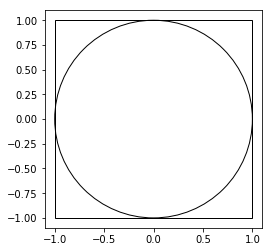

In [4]:
circle,box = makeBoxandCirclePlot(r,R)
fig, ax = plt.subplots()
ax.add_patch(circle)
ax.add_patch(box)
ax.axis('scaled')



## Define the function that will generate points within the space of the box/circle plot

In [5]:
def generatePoints(n=10):
    ##Function to generate some random points in the space of the square
    np.random.seed(42)
    points = np.vstack((np.random.uniform(-1,1,n),np.random.uniform(-1,1,n)))
    return points

## Lets generate some points and see what they look like on the circle.

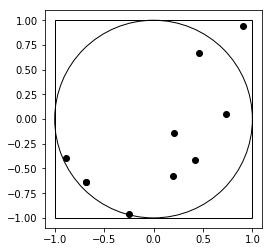

In [6]:
points = generatePoints(10)
ax.scatter(points[0],points[1],c='k')
fig


## Given that we know the formula for the area of the square is $(R*2)^2$ and the formula for the circle is ${\pi R^2}$, we can show that the ratio of the area of the circle to the area of the square is $\pi/4$. We can therefore get an estimate of the value of $\pi$ by multiplying the ratio of points inside the circle * 4.

### First, we need a function that can calculate the ratio of points inside the square.

In [7]:
def percentInCircle(radius,points,center_x=0,center_y=0):
    insidePointCount = 0
    for x,y in zip(points[0],points[1]):
        if euclidean((center_x,center_y),(x,y)) < radius:
            insidePointCount +=1
    outsidePoints = len(points[0])-insidePointCount
    percent = insidePointCount/(insidePointCount+outsidePoints)
    return percent

### Lets calculate the percentage of points in the circle and multiply it by 4.

In [8]:
percentage = percentInCircle(r,points)
percentage * 4

3.6

### So 3.6 ... not too close. I bet if I add more points, we'll get closer. Lets try that.

In [9]:
points = generatePoints(100)

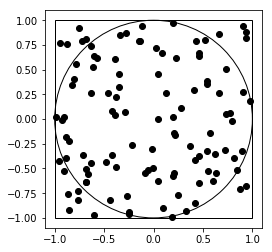

In [10]:
ax.scatter(points[0],points[1],c='k')
fig

In [11]:
percentage = percentInCircle(r,points)
percentage * 4

3.28

### Getting closer. Lets check this out for more points. Maybe we can plot the error vs the number of points used and see how that does. Here's a function that will do that:

In [12]:
def testPiN(pointList):
    trueValue = 3.1415
    piEstimates = []
    averageEstimates = []
    Ns = pointList
    for N in Ns:
        for i in range(0,4):
            points=generatePoints(int(N))
            pic = percentInCircle(r,points)
            piEstimate = pic * 4
            piEstimates.append(abs(trueValue-piEstimate))
        averageEstimates.append(np.mean(piEstimates))
        piEstimates.clear()
    return averageEstimates


### Lets try this out. We will do 10, 100, 1000, 10000, and 100000 points and compare the error as points increase.

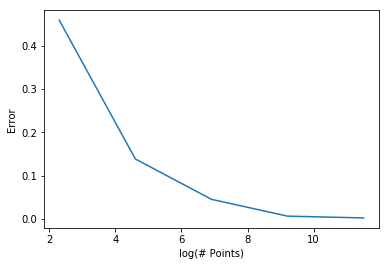

In [13]:
pointCounts = [10,100,1000,10000,100000]
averageError = testPiN(pointCounts)
plt.clf()
plt.plot(np.log(pointCounts),averageError)
plt.xlabel('log(# Points)')
plt.ylabel('Error')

### So we can see that error decreases as the number of points increases. We could add more points, but it becomes computationally expensive. Lets see how slow it is.

In [14]:
%time testPiN(pointCounts)

CPU times: user 10.9 s, sys: 169 ms, total: 11 s
Wall time: 11.4 s


[0.45849999999999991,
 0.13849999999999962,
 0.045500000000000096,
 0.0067000000000003723,
 0.0026199999999998447]

### So 11s per run. Not terrible, but lets see what we can do to fix that. We'll see about using some vectorization if possible.

In [15]:
def percentInCircleVec(radius,points,center_x=0,center_y=0):
    centerMatrix = np.vstack(([center_x] * len(points[0]), [center_y] * len(points[1])))
    distances = paired_euclidean_distances(points.T,centerMatrix.T)

    pointsInCircle = [value for value in distances if value < r]
    numPointsInCircle = len(pointsInCircle)/len(points[0])
    return(numPointsInCircle)
    

In [16]:
%time percentInCircle(r,points)
%time percentInCircleVec(r,points)



CPU times: user 6.77 ms, sys: 1.09 ms, total: 7.86 ms
Wall time: 10.3 ms
CPU times: user 845 µs, sys: 89 µs, total: 934 µs
Wall time: 909 µs


0.82

### So it looks like I can get about an 22X speedup by doing some vectorization. Let's rewrite the original function with this vectorized function.

In [17]:
def testPiNVec(pointList):
    trueValue = 3.1415
    piEstimates = []
    averageEstimates = []
    Ns = pointList
    for N in Ns:
        for i in range(0,4):
            points=generatePoints(int(N))
            pic = percentInCircleVec(r,points)
            piEstimate = pic * 4
            piEstimates.append(abs(trueValue-piEstimate))
        averageEstimates.append(np.mean(piEstimates))
        piEstimates.clear()
    return averageEstimates



In [18]:
%time testPiNVec(pointCounts)

CPU times: user 251 ms, sys: 13.3 ms, total: 265 ms
Wall time: 287 ms


[0.45849999999999991,
 0.13849999999999962,
 0.045500000000000096,
 0.0067000000000003723,
 0.0026199999999998447]

### So vectorizing the function that calculates whether or not a point is in the circle results in a 40 fold speed-up.